In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from dataset import Dataset
from model import SRCNN

In [2]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from model import SRCNN
c = 3
model  = SRCNN(c)
model.to(device)




SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

torch.Size([3, 64, 64])


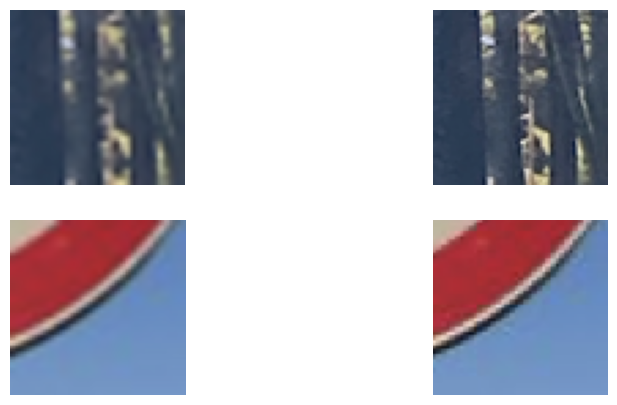

In [4]:
train = Dataset("./signs/trainLR/","./signs/trainHR/",2)
print(train[0][0].shape)

test = Dataset("./signs/validLR/", "./signs/validHR",2)
train_loader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
for lr, hr in train_loader:
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))

    # Plot the first image on the left
    axes[0][0].imshow(lr[0].permute(1,2,0))
    axes[0][0].axis('off')

    # Plot the second image on the right
    axes[0][1].imshow(hr[0].permute(1,2,0))
    axes[0][1].axis('off')
    
    axes[1][0].imshow(lr[1].permute(1,2,0))
    axes[1][0].axis('off')

    # Plot the second image on the right
    axes[1][1].imshow(hr[1].permute(1,2,0))
    axes[1][1].axis('off')

    # Show the images side by side
    plt.show()
    break

In [5]:
#hyperparameters
lr = 0.0000001
epochs = 300
batch_size = 256
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)



running_loss = 0
train_loss, test_loss = [],[]

model.train()
for epoch in range(epochs):
    print(epoch)
    for i, (lr,hr) in enumerate(train_loader):
        lr = lr.to(device)
        hr = hr.to(device)
        optimizer.zero_grad()
        out = model(lr)
        
        loss = criterion(out, hr)
        loss.backward()
        optimizer.step()
        running_loss+= loss.item()
    train_loss.append(running_loss/len(train_loader)) 
    running_loss = 0
    with torch.no_grad():
        model.eval()
        print('testing')
        for i, (lr,hr) in enumerate(testloader):
            lr = lr.to(device)
            hr = hr.to(device)
            out = model(lr)
            loss = criterion(out, hr)
            running_loss+= loss.item()
        test_loss.append(running_loss/len(testloader))
        running_loss = 0
        model.train()
    print(f'train loss: {train_loss[epoch]}\n test loss: {test_loss[epoch]}')
    if(epoch % 5 ==0):
        torch.save(model, f'./models/model{epoch}.pth')
        torch.save([train_loss, test_loss], f'./stats/stats-{epoch}.pt')

torch.save(model, f'./models/model{epoch}.pth')

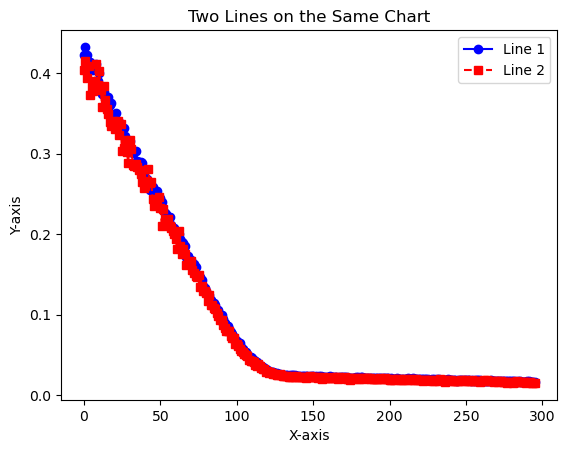

In [6]:

stats = torch.load('./stats/stats-295.pt')

# Create a figure and plot the two lines on the same chart
plt.plot(stats[0], marker='o', linestyle='-', color='b', label='Line 1')
plt.plot(stats[1], marker='s', linestyle='--', color='r', label='Line 2')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Lines on the Same Chart')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


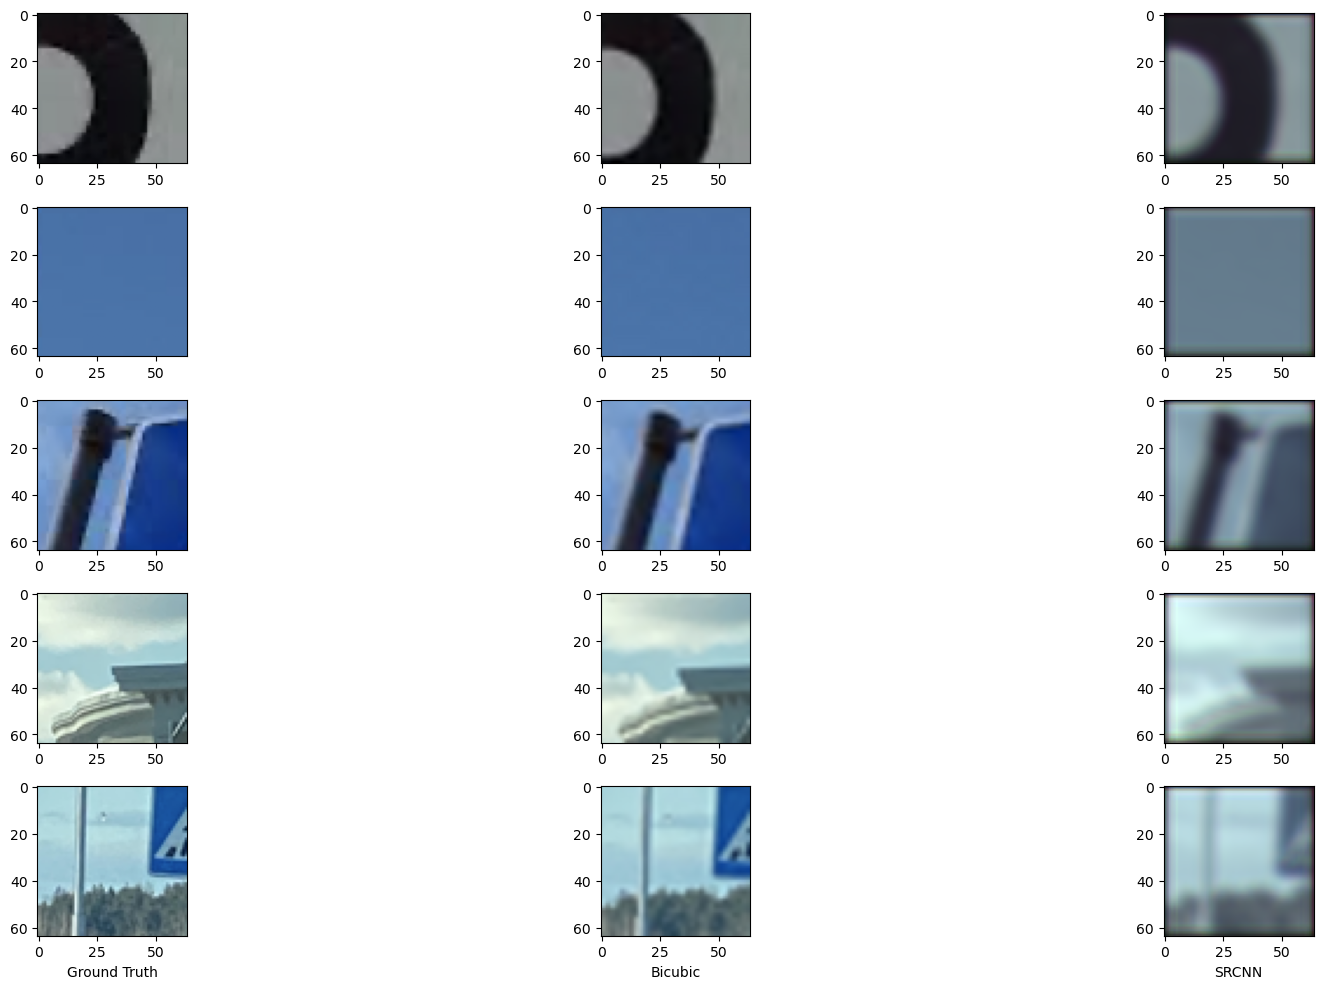

In [11]:
model = torch.load("./models/model299.pth").to(device)
examples = 5
model.eval()
fig_test = test = Dataset("./signs/validLR/", "./signs/validHR",2)
testloader = torch.utils.data.DataLoader(fig_test, batch_size=1, shuffle=False)
with torch.no_grad():
    fig, axes = plt.subplots(examples, 3, figsize=(20, 10))
    for i, (lr, hr) in enumerate(testloader):
        if i == examples:
            break
        
        # Plot the first image on the 
        
        
        axes[i][1].imshow(lr[0].permute(1,2,0))
       
        axes[i][0].imshow(hr[0].permute(1,2,0))

        lr = model(lr.to(device)).cpu()
        axes[i][2].imshow(lr[0].permute(1,2,0))
        
        
        
    axes[examples -1][0].set_xlabel('Ground Truth')
    axes[examples-1][1].set_xlabel('Bicubic')
    axes[examples-1][2].set_xlabel('SRCNN')
    plt.tight_layout()
    plt.show()


In [8]:
from utils import PSNR_func
from torchvision import transforms
import numpy as np
psnr = 0

test = Dataset("./signs/validLR/", "./signs/validHR",2, False)
testloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)
print(len(testloader))
with torch.no_grad():
    for i, (lr,hr) in enumerate(testloader):
        
        lr = lr.to(device).squeeze(0)
        
        hr = hr.to(device)
        # print(hr.shape)
        # print(lr.shape)
        if(lr.shape[1] > hr.shape[2]):
            lr = lr[:,:-1,:]
        if(lr.shape[2] > hr.shape[3]):
            lr = lr[:,:,:-1]
       
    
        lr = transforms.ToPILImage()(lr.clamp(0,255))
        
        
        hr = transforms.ToPILImage()(hr.squeeze(0))
        
        lr = np.asarray(lr)
        hr = np.asarray(hr)
        
       
        psnr += PSNR_func(lr, hr)
        
    print(psnr/175)

175
34.08636982025689
